# Project 3: Collaboration and Competition

---

We train 2 agents, with rackets, playing tennis to collaborate and score +0.5 on tennis.  

Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
print('[ info ] Brain name',brain_name)
print('[ info ] Brain', brain)

[ info ] Brain name TennisBrain
[ info ] Brain Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [7]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Actor (Policy) Model and Critic (Value) Model
The Actor-Critic Architecture is the intersection of policy-based and value-based methods for deep reinforcement learning.
This is also the basis for both Deterministic Policy Gradient and Deep Deterministic Policy Gradient Methods and here we implement the later.

In [8]:
from hyperparams import *
from model import Actor, Critic
from agent import Agent
from ounoise import OUNoise
from replaybuffer import ReplayBuffer

Lets look at our current hyperparameters. These are used for tuning the deep learning networks by the agent during training.

In [9]:
params

{'BUFFER_SIZE': 1000000,
 'BATCH_SIZE': 256,
 'GAMMA': 0.99,
 'TAU': 0.001,
 'LR_ACTOR': 0.0001,
 'LR_CRITIC': 0.001,
 'WEIGHT_DECAY': 0.0,
 'DEVICE': device(type='cuda', index=0)}

In [10]:
actor = Actor(state_size, action_size)
print(actor)

Actor(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)


In [11]:
critic = Critic(state_size, action_size)
print(critic)

Critic(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=402, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### 6. Deep Deterministic Policy Gradient (DDPG) Agent and supporting components (OUNoise, ReplayBuffer and DDPG Agent)
The DDPG Agent supports multi-agent configuration. So it actually is an MADDPG.

In [12]:
agent = Agent(state_size, action_size, num_agents, random_seed = 0, params = params)
agent

### 7. Training the multi-agent Agent with DDPG
Now we train our agent. The only different here is how we compute the score per episode - where we get the maximum score from the two agents. We write a special ddpg function for this.

In [13]:
def ddpg(n_episodes = 5000, max_t = 1000):
    scores_deque = deque(maxlen = 100) #
    scores_all = [] #
    max_score = -np.inf #
    
    # Episodes
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode = True)[brain_name] #
        states = env_info.vector_observations # Since we have multiple agents, each agent has a state
        agent.reset() #
        scores = np.zeros(num_agents) #
        max_score = -np.inf
        # Timesteps
        for t in range(max_t):
            actions = agent.act(states) #
            env_info = env.step(actions)[brain_name] #
            next_states = env_info.vector_observations # All next states for all agents
            rewards = env_info.rewards # all rewards for all agents
            dones = env_info.local_done # episodes dones for all agents
            agent.step(states, actions, rewards, next_states, dones) #
            states = next_states # update to next states
            scores += rewards # tally up the scores here
            if np.any(dones): #
                break #
        episode_avg_score = np.max(scores) # We need the maximum score instead of the mean.
        scores_deque.append(episode_avg_score)
        scores_all.append(episode_avg_score)
        average_score = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, average_score, episode_avg_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if average_score >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
            # Final save
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return scores_all

Episode 100	Average Score: 0.01	Score: 0.00
Episode 200	Average Score: 0.01	Score: 0.00
Episode 300	Average Score: 0.00	Score: 0.00
Episode 400	Average Score: 0.00	Score: 0.09
Episode 500	Average Score: 0.01	Score: 0.09
Episode 600	Average Score: 0.01	Score: 0.00
Episode 700	Average Score: 0.01	Score: 0.00
Episode 800	Average Score: 0.07	Score: 0.10
Episode 900	Average Score: 0.08	Score: 0.10
Episode 1000	Average Score: 0.10	Score: 0.10
Episode 1100	Average Score: 0.22	Score: 0.20
Episode 1200	Average Score: 0.43	Score: 0.10
Episode 1300	Average Score: 0.38	Score: 0.50
Episode 1346	Average Score: 0.51	Score: 2.60
Environment solved in 1346 episodes!	Average Score: 0.51


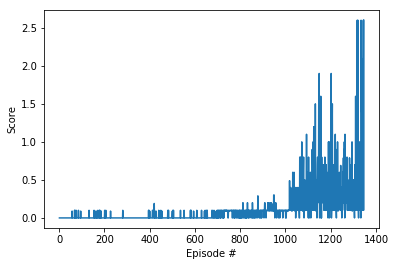

In [14]:
scores = ddpg()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()